In [1]:
!pip install statsmodels
!pip install pyspark
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
import findspark
findspark.init()
import pyspark

sc = pyspark.SparkContext(master='spark://hd-master:7077',
                          appName='big_data')

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/30 12:12:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark = SQLContext(sc)

/home/hadoop/.local/lib/python3.10/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [5]:
df = spark.read.option("header",True).csv("hdfs://hd-master:9000/covid-19", inferSchema=True)

In [6]:
df.show(5,truncate=False)

+-----------+----------+---------+---------+------+
|country    |date      |confirmed|recovered|deaths|
+-----------+----------+---------+---------+------+
|afghanistan|2020-01-22|0        |0        |0     |
|afghanistan|2020-01-23|0        |0        |0     |
|afghanistan|2020-01-24|0        |0        |0     |
|afghanistan|2020-01-25|0        |0        |0     |
|afghanistan|2020-01-26|0        |0        |0     |
+-----------+----------+---------+---------+------+
only showing top 5 rows



In [7]:
# Global Parameters
time_seires_num = 30
country_you_want_to_predict = "china"
case_you_want_to_predict = "confirmed"
prediction_date = "2022-09-01" # The date should not exceed 2023-03-10

In [8]:
df = df.filter(df['country']==country_you_want_to_predict).select("date", case_you_want_to_predict)
df = df.withColumnRenamed(case_you_want_to_predict, "cases")

In [9]:
df.show(5,truncate=False)

+----------+-----+
|date      |cases|
+----------+-----+
|2020-01-22|548  |
|2020-01-23|643  |
|2020-01-24|920  |
|2020-01-25|1406 |
|2020-01-26|2075 |
+----------+-----+
only showing top 5 rows



In [10]:
def predict_time_series_arima(prediction_date):
    data = df

    prediction_date_dt = datetime.strptime(prediction_date, "%Y-%m-%d")
    first_date_in_training_set = prediction_date_dt - timedelta(days=time_seires_num)
    last_date_in_training_set = prediction_date_dt - timedelta(days=1)

    true_value = data.filter(col("date") == prediction_date).select("cases").collect()[0]["cases"]
    
    data = data.filter((col("date")>=first_date_in_training_set) & (col("date")<=last_date_in_training_set))
    
    assembler = VectorAssembler(inputCols=["cases"], outputCol="features")
    assembled_data = assembler.transform(data)

    np_data = np.array(assembled_data.select("features").rdd.map(lambda x: x[0].toArray()[0]).collect())

    order = (1, 1, 1)
    model = ARIMA(np_data, order=order)
    fit_model = model.fit()

    prediction_value = int(fit_model.forecast(1)[0])
    error = abs(prediction_value - true_value)/true_value*100
    #print(f"Predicted value for {prediction_date}: {prediction_value}; True value for {prediction_date}: {true_value}; The error is: {error}%")
    return prediction_value, true_value, error

In [11]:
# Specify the list of dates for prediction
date_list = ["2022-07-01", "2022-08-01","2022-09-01", "2022-10-01", "2022-11-01", "2022-12-01"]

In [12]:
def predict_multi_date(date_list):
    x=date_list
    pred_value=[]
    true_value=[]
    error=[]
    for date in date_list:
        pred, true, err = predict_time_series_arima(date)
        pred_value.append(pred)
        true_value.append(true)
        error.append(err)

    plt.plot(x, true_value, 'b', label='true')
    plt.plot(x, pred_value, 'y', label='predict')
    plt.legend(['true', 'predict'])
    plt.rcParams.update({'font.size': 7})
    
    for i in range(len(x)):
        plt.text(x[i], true_value[i], "True Value: "+str(true_value[i])+"\n Predict Value: "+str(pred_value[i])+"\n Error: "+str(error[i]))

    plt.show()

/home/hadoop/.local/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/hadoop/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hadoop/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hadoop/.local/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/hadoop/.local/lib/python3.10/site-packages/s

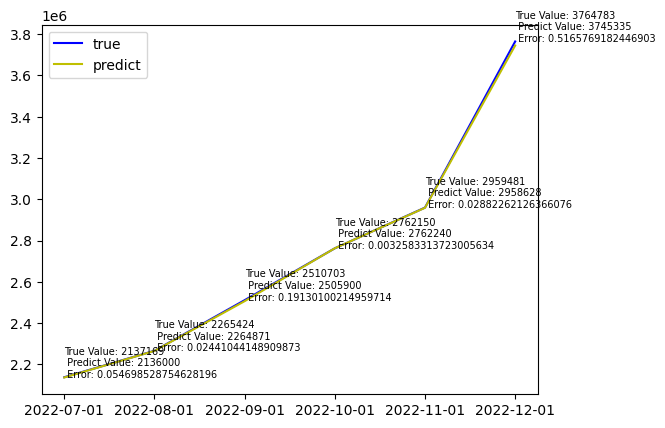

In [13]:
predict_multi_date(date_list)

In [14]:
sc.stop()